In [1]:
import importlib
import sys
import pandas as pd
import matplotlib.pyplot as plt
from helper import (normalize,
                    time_series_dataset,
                    time_series_dataset_split,
                    time_series_train_test_split,
                    time_series_train_test_split_multiple,
                    create_seq_fast_multiple as create_seq_multiple,
                    train_model)
import torch

WINDOW_SIZE = 10

In [2]:
# Leitura do dataset
trips_ev = pd.read_csv('../data/eletrico_ieee.csv')

selected_columns = [
    'Trip',
    'Time [s]',
    'Velocity [km/h]',
    'Throttle [%]',
    'Motor Torque [Nm]',
    'CO2 Emissions'
]
trips_ev = trips_ev[selected_columns]
trips_ev.head()


,Trip,Time [s],Velocity [km/h],Throttle [%],Motor Torque [Nm],CO2 Emissions
0,TripA01,0.0,0.0,0.0,0.0,0.009209
1,TripA01,0.1,0.0,0.0,0.0,0.009251
2,TripA01,0.2,0.0,0.0,0.0,0.009460
3,TripA01,0.3,0.0,0.0,0.0,0.009627
4,TripA01,0.4,0.0,0.0,0.0,0.009627


In [3]:
# Data normalization
trips_ev_scaled, trips_ev_X_scaler = normalize(trips_ev, ['Velocity [km/h]', 'Throttle [%]', 'Motor Torque [Nm]'], 'CO2 Emissions')
trips_ev_scaled.head()

,Velocity [km/h],Throttle [%],Motor Torque [Nm],Trip,CO2 Emissions
0,0.0,0.0,0.260522,TripA01,0.009209
1,0.0,0.0,0.260522,TripA01,0.009251
2,0.0,0.0,0.260522,TripA01,0.009460
3,0.0,0.0,0.260522,TripA01,0.009627
4,0.0,0.0,0.260522,TripA01,0.009627


In [4]:
importlib.reload(sys.modules['helper'])
from helper import time_series_dataset_split

ev_x_train_seq, ev_y_train_seq, ev_x_test, ev_y_test  = time_series_dataset_split(trips_ev_scaled, ['CO2 Emissions'], 'Trip')

print("Train:")
print(f"trips_ev_X_train_seq {ev_x_train_seq.shape}")
print(f"trips_ev_y_train_seq {ev_y_train_seq.shape}")
print("\nTEST:")
print(f"trips_ev_X_test_seq {len(ev_x_test)}")
print(f"trips_ev_y_test_seq {len(ev_y_test)}")

Train:
trips_ev_X_train_seq torch.Size([924218, 10, 3])
trips_ev_y_train_seq torch.Size([924218, 1])

TEST:
trips_ev_X_test_seq 14
trips_ev_y_test_seq 14


In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Current device index:", torch.cuda.current_device())
else:
    print("No GPU detected.")

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1
GPU name: NVIDIA A100-SXM4-40GB
Current device index: 0


Model config:LSTMModel(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Epoch 1/20
Train Loss: 0.017768, Val Loss: 0.014328, LR: 0.000208

Epoch 2/20
Train Loss: 0.006070, Val Loss: 0.004768, LR: 0.000406

Epoch 3/20
Train Loss: 0.004739, Val Loss: 0.004161, LR: 0.000604

Epoch 4/20
Train Loss: 0.004206, Val Loss: 0.003831, LR: 0.000802

Epoch 5/20
Train Loss: 0.004011, Val Loss: 0.003924, LR: 0.001000

Epoch 6/20
Train Loss: 0.003862, Val Loss: 0.003623, LR: 0.000989

Epoch 7/20
Train Loss: 0.003753, Val Loss: 0.003639, LR: 0.000957

Epoch 8/20
Train Loss: 0.003692, Val Loss: 0.003585, LR: 0.000905

Epoch 9/20
Train Loss: 0.003643, Val Loss: 0.003545, LR: 0.000835

Epoch 10/20
Train Loss: 0.003612, Val Loss: 0.003510, LR: 0.000750

Epoch 11/20
Train Lo

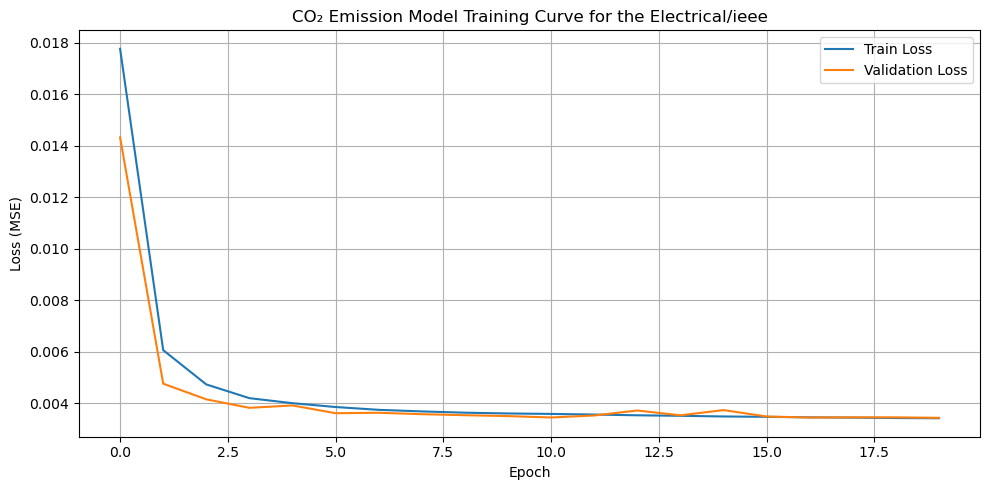


Final MAE: 0.02803904, Final MSE: 0.00344320
Max memory allocated: 0.03 GB


In [5]:
ev_model = train_model(ev_x_train_seq, ev_y_train_seq, title='CO₂ Emission Model Training Curve for the Electrical/ieee', train_size=0.8, epochs=20, batch_size=256)

In [8]:
len(ev_x_test)

14

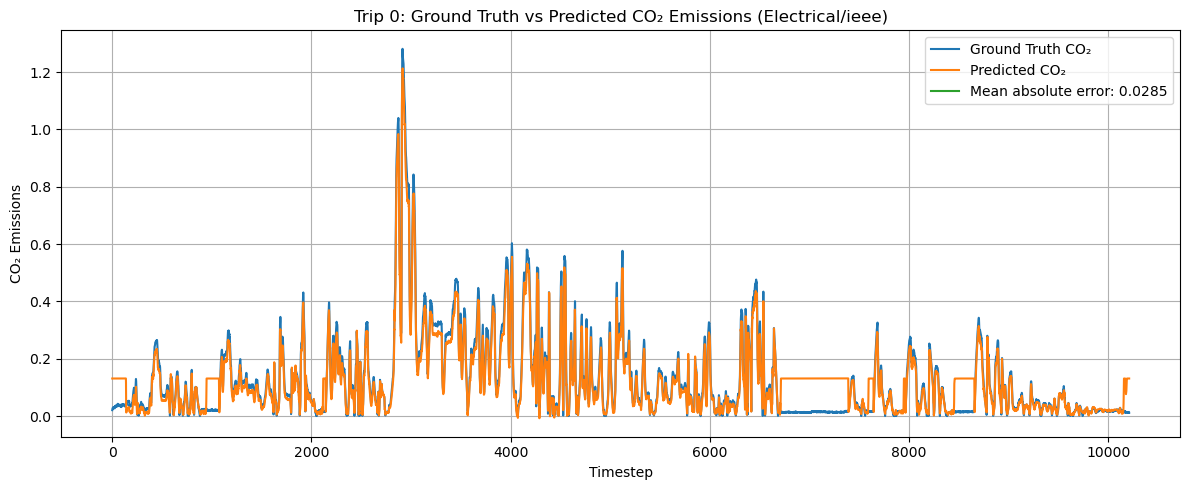

In [26]:
trip_num = 0
trip_test_x, trip_test_y = ev_x_test[trip_num], ev_y_test[trip_num]

errors = []
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i]
    x = sequence.unsqueeze(0).to('cuda') # add batch dim
    with torch.inference_mode():
        pred = ev_model(x).squeeze(0)
        prediction_list.append(pred)

predicted = torch.stack(prediction_list).cpu() # shape: (T - WINDOW_SIZE, output_size)
true = trip_test_y.cpu() # match prediction window

difference = predicted - true
mae = torch.mean(abs(difference))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true, label='Ground Truth CO₂')
plt.plot(predicted, label='Predicted CO₂')
plt.plot(0, label=f'Mean absolute error: %.4f' % mae)
plt.xlabel('Timestep')
plt.ylabel('CO₂ Emissions')
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(f'Trip {trip_num}: Ground Truth vs Predicted CO₂ Emissions (Electrical/ieee)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Torque & Throttle Predictions

In [6]:
# Leitura do dataset
trips_ev = pd.read_csv('../data/eletrico_ieee.csv')

selected_columns = [
    'Velocity [km/h]', 
    'Ambient Temperature [°C]', 
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Motor Torque [Nm]',
    'Throttle [%]',
    'Trip'
]

trips_ev = trips_ev[selected_columns]


# Normalização
trips_ev_scaled, trips_ev_X_scaler = normalize(
    trips_ev, 
    [
        'Velocity [km/h]', 
        'Ambient Temperature [°C]', 
        'Cabin Temperature Sensor [°C]',
        'Longitudinal Acceleration [m/s^2]'
    ], 
    ['Motor Torque [Nm]', 'Throttle [%]']
)
trips_ev_scaled.head()

,Velocity [km/h],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Longitudinal Acceleration [m/s^2],Trip,Motor Torque [Nm],Throttle [%]
0,0.0,0.783784,0.485904,0.667161,TripA01,0.0,0.0
1,0.0,0.783784,0.485904,0.669385,TripA01,0.0,0.0
2,0.0,0.783784,0.485904,0.668643,TripA01,0.0,0.0
3,0.0,0.783784,0.485904,0.667161,TripA01,0.0,0.0
4,0.0,0.783784,0.485904,0.667161,TripA01,0.0,0.0


14

In [8]:
ev_x_train_seq, ev_y_train_seq, ev_x_test, ev_y_test = time_series_dataset_split(trips_ev_scaled, ['Motor Torque [Nm]', 'Throttle [%]'], 'Trip')

print(f"trips_ev_X_train_seq {ev_x_train_seq.shape}")
print(f"trips_ev_y_train_seq {ev_y_train_seq.shape}")
print("\nTEST:")
print(f"trips_ev_X_test_seq {len(ev_x_test)}")
print(f"trips_ev_y_test_seq {len(ev_y_test)}")


trips_ev_X_train_seq torch.Size([924218, 10, 4])
trips_ev_y_train_seq torch.Size([924218, 2])

TEST:
trips_ev_X_test_seq 14
trips_ev_y_test_seq 14


Model config:LSTMModel(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Epoch 1/20
Train Loss: 1153.167959, Val Loss: 1123.265079, LR: 0.000208

Epoch 2/20
Train Loss: 519.314467, Val Loss: 183.071096, LR: 0.000406

Epoch 3/20
Train Loss: 106.389167, Val Loss: 69.979999, LR: 0.000604

Epoch 4/20
Train Loss: 71.939063, Val Loss: 64.785760, LR: 0.000802

Epoch 5/20
Train Loss: 67.077472, Val Loss: 59.505513, LR: 0.001000

Epoch 6/20
Train Loss: 62.994178, Val Loss: 59.328948, LR: 0.000989

Epoch 7/20
Train Loss: 59.893994, Val Loss: 54.282610, LR: 0.000957

Epoch 8/20
Train Loss: 57.263558, Val Loss: 53.872470, LR: 0.000905

Epoch 9/20
Train Loss: 54.734338, Val Loss: 50.430428, LR: 0.000835

Epoch 10/20
Train Loss: 53.018568, Val Loss: 50.890107, LR: 0.0

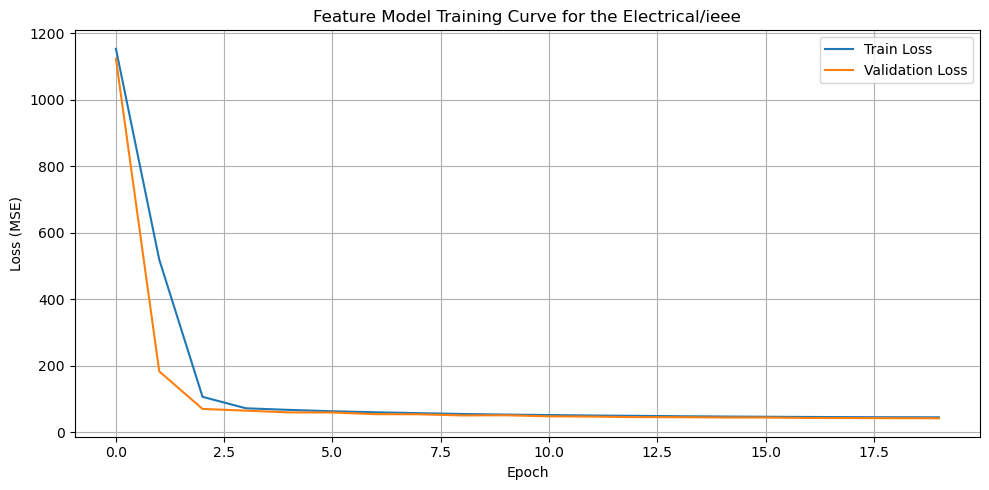


Final MAE: 3.74190822, Final MSE: 41.95795514
Max memory allocated: 0.03 GB


In [9]:
to_th_model = train_model(ev_x_train_seq, ev_y_train_seq, title='Feature Model Training Curve for the Electrical/ieee', train_size=0.8, epochs=20, batch_size=128)

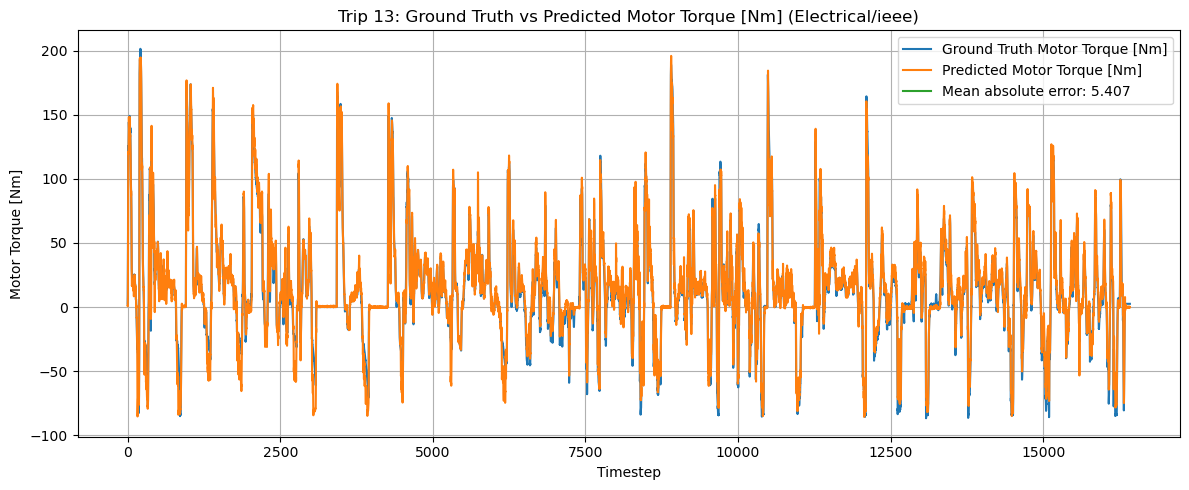

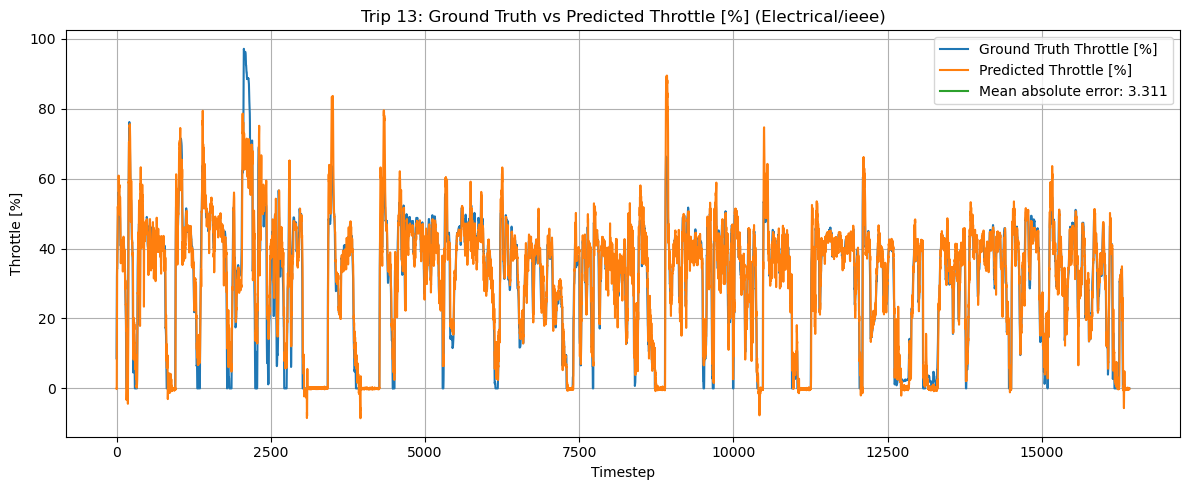

In [23]:
trip_num = 13

trip_test_x, trip_test_y = ev_x_test[trip_num], ev_y_test[trip_num]

# Predict using the model
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i].unsqueeze(0).to('cuda')  # Add batch dimension
    with torch.inference_mode():
        pred = to_th_model(sequence).squeeze(0)  # Shape: (2,)
        prediction_list.append(pred)

predicted = torch.stack(prediction_list).cpu()  # Shape: (T - WINDOW_SIZE, 2)
true = trip_test_y.cpu()  # Shape: (T - WINDOW_SIZE, 2)

# Names for each output
output_labels = ['Motor Torque [Nm]', 'Throttle [%]']

# Plot each output
for i in range(predicted.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(true[:, i], label=f'Ground Truth {output_labels[i]}')
    plt.plot(predicted[:, i], label=f'Predicted {output_labels[i]}')
    difference = predicted[:, i] - true[:, i]
    mae = torch.mean(abs(difference))
    plt.plot(0, label=f'Mean absolute error: %.3f' % mae)
    plt.xlabel('Timestep')
    plt.ylabel(output_labels[i])
    plt.title(f'Trip {trip_num}: Ground Truth vs Predicted {output_labels[i]} (Electrical/ieee)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# "Proxy" Validation


In [25]:
trips_ev = pd.read_csv('../data/eletrico_ieee.csv')

selected_columns = [
    'Velocity [km/h]', 
    'Ambient Temperature [°C]', 
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Motor Torque [Nm]',
    'Throttle [%]',
    'Trip'
]

trips_ev = trips_ev[selected_columns]


# Normalização
trips_ev_scaled, trips_ev_X_scaler_1 = normalize(
    trips_ev, 
    [
        'Velocity [km/h]', 
        'Ambient Temperature [°C]', 
        'Cabin Temperature Sensor [°C]',
        'Longitudinal Acceleration [m/s^2]'
    ], 
    ['Motor Torque [Nm]', 'Throttle [%]']
)
ev_x_train_seq_1, ev_y_train_seq_1, ev_x_test_1, ev_y_test_1 = time_series_dataset_split(trips_ev_scaled, ['Motor Torque [Nm]', 'Throttle [%]'], 'Trip')



In [26]:
trips_ev = pd.read_csv('../data/eletrico_ieee.csv')

selected_columns = [
    'Trip',
    'Time [s]',
    'Velocity [km/h]',
    'Throttle [%]',
    'Motor Torque [Nm]',
    'Ambient Temperature [°C]',
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'CO2 Emissions'
]
trips_ev = trips_ev[selected_columns]

trips_ev_scaled, trips_ev_X_scaler_2 = normalize(
    trips_ev,
    [
        'Velocity [km/h]',
        'Throttle [%]',
        'Motor Torque [Nm]'
    ],
    'CO2 Emissions'
)

ev_x_train_seq_2, ev_y_train_seq_2, ev_x_test_2, ev_y_test_2  = time_series_dataset_split(trips_ev_scaled, ['CO2 Emissions'], 'Trip')

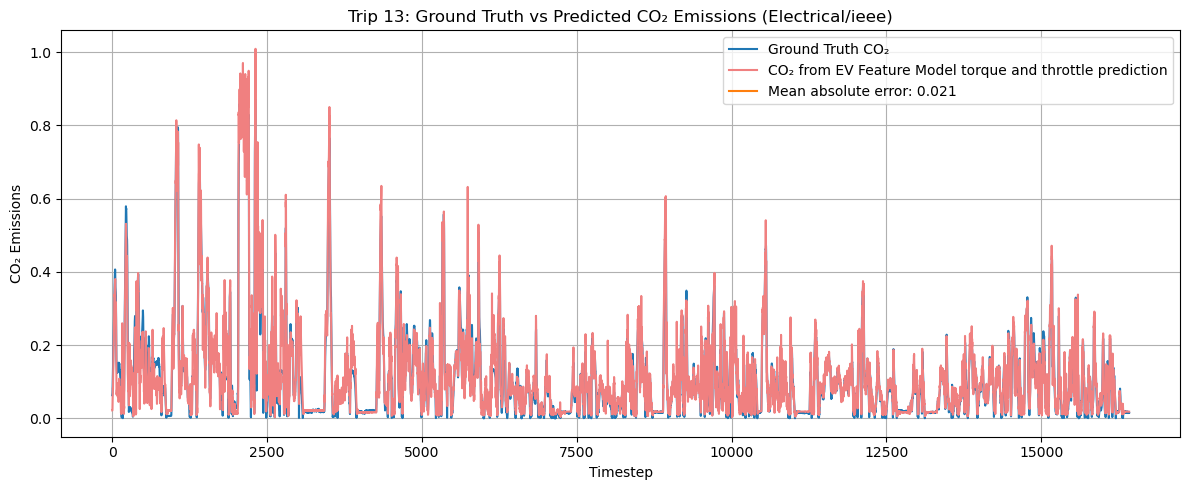

In [42]:
trip_num = 13

trip_test_x, trip_test_y = ev_x_test_1[trip_num], ev_y_test_1[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

# Predict using the model
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i]
    x = sequence.unsqueeze(0).to('cuda') # add batch dim
    with torch.inference_mode():
        prediction = to_th_model(x, full_sequence=True).squeeze(0).cpu()
        torque, throttle = prediction[:,0], prediction[:,1]
        # Min/Max Normalization of predictions
        torque = ((torque - trips_ev_X_scaler_2.data_min_[2])/ (trips_ev_X_scaler_2.data_max_[2] - trips_ev_X_scaler_2.data_min_[2]))
        throttle = ((throttle - trips_ev_X_scaler_2.data_min_[1])/ (trips_ev_X_scaler_2.data_max_[1] - trips_ev_X_scaler_2.data_min_[1]))
        velocity = sequence[:,0]
        x = torch.stack([velocity, throttle, torque], dim=1).unsqueeze(0).to('cuda') 
        pred = ev_model(x).squeeze(0)        
        prediction_list.append(pred)

predicted_from_equivalent = torch.stack(prediction_list).cpu()  # Predicted co2 emissions from equivalent model's throttle and torque features

trip_test_x, trip_test_y = ev_x_test_2[trip_num], ev_y_test_2[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

#prediction_list = []
#for i in range(len(trip_test_x)):
#    sequence = trip_test_x[i]
#    x = sequence.unsqueeze(0).to('cuda') # add batch dim
#    with torch.inference_mode():
#        pred = ev_model(x).squeeze(0)
#        prediction_list.append(pred)

#predicted_from_original_features = torch.stack(prediction_list).cpu() 

true = trip_test_y.cpu() # match prediction window

difference_r_true = predicted_from_equivalent - true
mae_true = torch.mean(abs(difference_r_true))

#difference_r_original = predicted_from_equivalent - predicted_from_original_features
#mae_original = torch.mean(abs(difference_r_original))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true, label='Ground Truth CO₂')
plt.plot(predicted_from_equivalent, label='CO₂ from EV Feature Model torque and throttle prediction', color='lightcoral')
plt.plot(0, label=f'Mean absolute error: %.3f' % mae_true)

plt.xlabel('Timestep')
plt.ylabel('CO₂ Emissions')
plt.title(f'Trip {trip_num}: Ground Truth vs Predicted CO₂ Emissions (Electrical/ieee)')
plt.legend()#loc='upper right'
plt.grid(True)
plt.tight_layout()
plt.show()